# Multi-modal and multi-vendor retina image registration
## Reimplementation by Olivier Morelle

In [1]:
def center_crop(img, size):
    center = img.shape[0] // 2, img.shape[1] // 2
    
    height_range = center[0] - size[0] // 2, center[0] + size[0] // 2
    width_range = center[1] - size[1] // 2, center[1] + size[1] // 2
    return img[height_range[0]:height_range[1],
               width_range[0]:width_range[1],
               :]
    

In [2]:
import eyepy as ep
import imageio
import matplotlib.pyplot as plt

from skimage.feature import hog, canny, plot_matches
from skimage import exposure

import numpy as np
from PIL import Image

import imageio

## Read Data, Crop and Resize

In [3]:
with ep.io.VolReader("/home/morelle/data/oct_raw/ExportRAWanonymized/67007_20190515.vol") as reader:
    nir_img = reader.read_nir()
    
cfp_img = imageio.imread("/home/morelle/data/oct_raw/ExportRAWanonymized/HS00+0EZ.003.BMP")
cfp_img = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))


im = Image.fromarray(cfp_img)
im.thumbnail(nir_img.shape, Image.ANTIALIAS)

cfp_img = np.array(im)


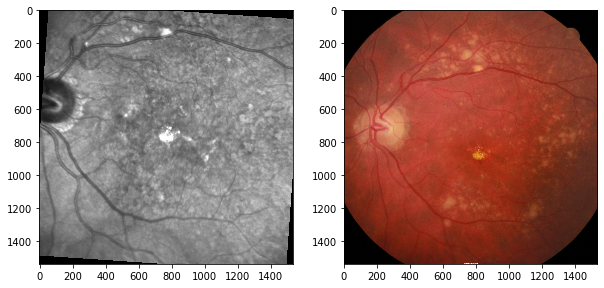

In [4]:
#imageio.imwrite("/home/morelle/Projects/octave/nir.tif", nir_img)
#imageio.imwrite("/home/morelle/Projects/octave/cfp.tif", cfp_img[..., 1])
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(nir_img, cmap="gray")
ax2.imshow(cfp_img, cmap="gray")

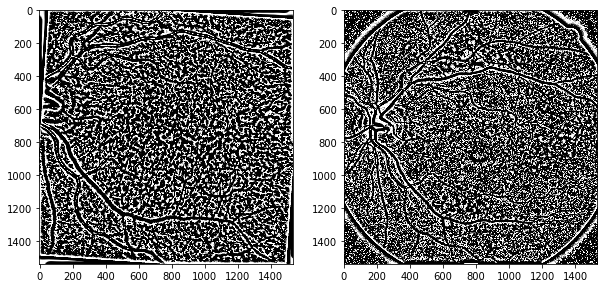

In [493]:
nir_pc = imageio.imread("/home/morelle/Projects/octave/nir_pc.tiff")
cfp_pc = imageio.imread("/home/morelle/Projects/octave/cfp_pc.tiff")

nir_pc = (nir_pc/nir_pc.max() * np.pi) -np.pi/2
cfp_pc = (cfp_pc/cfp_pc.max() * np.pi) -np.pi/2

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(nir_pc, cmap="gray")
ax2.imshow(cfp_pc, cmap="gray")

## Mean phase images

In [1]:
from loggabor import mean_phase

In [21]:
min_wavelength = 9
n_scale=4
n_orient=6
sigma=0.55

nir_mp = np.log(mean_phase(nir_img, min_wavelength, sigma, n_scale, n_orient))
cfp_mp_r = np.log(mean_phase(cfp_img[..., 0], min_wavelength, sigma, n_scale, n_orient))
cfp_mp_g = np.log(mean_phase(cfp_img[..., 1], min_wavelength, sigma, n_scale, n_orient))
cfp_mp_b = np.log(mean_phase(cfp_img[..., 2], min_wavelength, sigma, n_scale, n_orient))

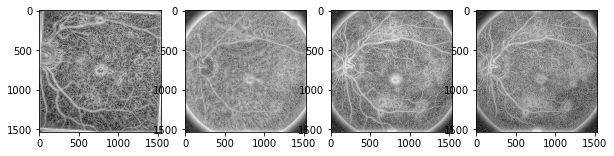

In [22]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(10,40))
ax0.imshow(nir_mp, cmap="gray")
ax1.imshow(cfp_mp_r, cmap="gray")
ax2.imshow(cfp_mp_g, cmap="gray")
ax3.imshow(cfp_mp_b, cmap="gray")

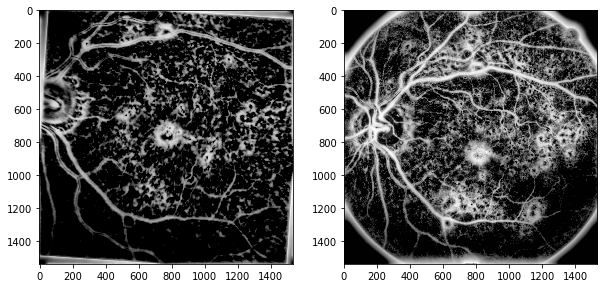

In [33]:
cfp_mp = (cfp_mp_r + cfp_mp_g + cfp_mp_b)/3

from skimage.exposure import match_histograms, equalize_adapthist

nir_mp2 = nir_mp+abs(nir_mp.min())
nir_mp2 = (nir_mp2/nir_mp2.max())*2-1

cfp_mp2 = cfp_mp+abs(cfp_mp.min())
cfp_mp2 = (cfp_mp2/cfp_mp2.max())*2-1
#cfp_pc = (cfp_pc/cfp_pc.max() * np.pi) -np.pi/2
nir_mp2 = equalize_adapthist(nir_mp2)
cfp_mp2 = equalize_adapthist(cfp_mp2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(nir_mp2, cmap="gray")
ax2.imshow(cfp_mp2, cmap="gray")

In [30]:
nir_mp.max()

3.6645212807540184

## Detect Features

In [35]:
from skimage.feature import ORB
def orb_detect_extract(img, **kwargs):
    descriptor_extractor = ORB(**kwargs)
    descriptor_extractor.detect_and_extract(img)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    return keypoints, descriptors

In [38]:
from skimage.feature import match_descriptors

dest_key, dest_feat = orb_detect_extract(nir_mp2, n_keypoints=500, harris_k=0.2, n_scales=30, downscale=1.1)
src_key, src_feat = orb_detect_extract(cfp_mp2, n_keypoints=500, harris_k=0.2, n_scales=30, downscale=1.1)
matches = match_descriptors(dest_feat, src_feat)

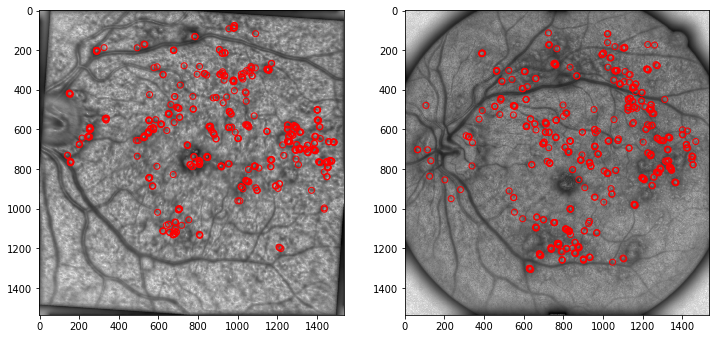

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(-nir_mp, cmap=plt.cm.gray)
ax[0].scatter(dest_key[:, 1], dest_key[:, 0], facecolors='none', edgecolors='r')

ax[1].imshow(-cfp_mp, cmap=plt.cm.gray)
ax[1].scatter(src_key[:, 1], src_key[:, 0], facecolors='none', edgecolors='r')

## Apply HOG on Data

In [1456]:
M=20
N=5
orientations = 12

fd_nir, nir_hog = hog(nir_mp, orientations=orientations, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)


fd_cfp, cfp_hog = hog(cfp_mp, orientations=orientations, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)

ss_nir_hog = fd_nir[::2, ::2, ...]
ss_cfp_hog = fd_cfp[::2, ::2, ...]

def rotate_hog(hog_features):
    """
    
    
    """
    orientations = hog_features.shape[-1]
    M = hog_features.shape[-2]
    rotated_hog = np.zeros(hog_features.shape[:2]+(orientations, M, M, orientations))
    for block in np.ndindex(hog_features.shape[:2]):
        for rot in range(orientations):
            rotated_hog[block][rot] = np.roll(hog_features[block], rot, axis=-1)
            
    return rotated_hog

ss_nir_rotated_hog = rotate_hog(ss_nir_hog)

In [1300]:
#fd_rotated_nir = np.zeros(fd_nir_5.shape[:2]+(orientations, M, M, orientations))

#for block in np.ndindex(fd_nir_5.shape[:2]):
#    for rot in range(orientations):
#        fd_rotated_nir[block][rot] = np.roll(fd_nir_5[block], rot, axis=-1)

(-0.5, 1535.5, 1535.5, -0.5)

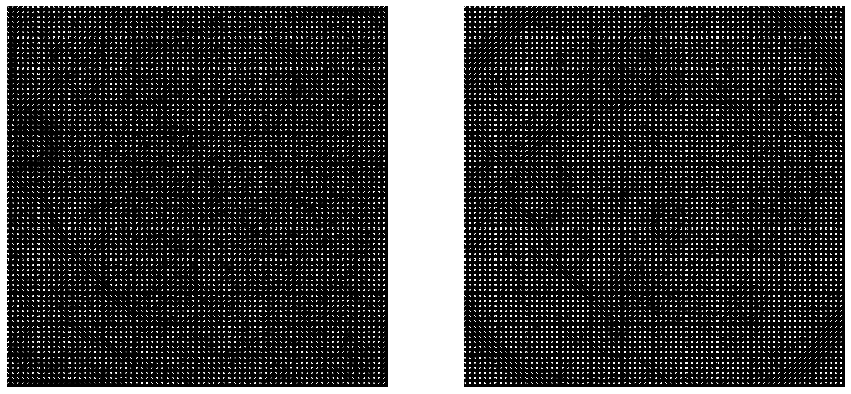

In [1464]:
nir_hog_image = exposure.rescale_intensity(nir_hog, in_range=(0, 0.05))
cfp_hog_image = exposure.rescale_intensity(cfp_hog, in_range=(0, 0.05))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

s = np.s_[...]
ax1.imshow(nir_hog_image[s], cmap="gray")
ax2.imshow(cfp_hog_image[s], cmap="gray")

ax1.axis("off")
ax2.axis("off")

## Match approximate nearest neighbours in hog

Here I used a nearest neighbour approach from sklearn. I could also try to use the annoy package.

In [1439]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
def ann(src, dest, n_trees=10, metric="euc"):
    """ Searches ANN for src in dest
    
    For every feature in src the index and distanc of the ann in dest is returned 
    
    Assumes that features are on the last axis
    
    metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"
    """
    orig_src_shape = src.shape[:-1]
    orig_dest_shape = dest.shape[:-1]
    
    # Compress index axis into one axis
    src = src.reshape((np.prod(orig_src_shape), -1))
    dest = dest.reshape((np.prod(orig_dest_shape), -1))
    
    t = AnnoyIndex(dest.shape[-1], 'euclidean')
    for i in range(dest.shape[0]):
        t.add_item(i, dest[i])

    t.build(n_trees)
    
    
    dest_indices = np.empty(src.shape[0], dtype=np.int)
    dest_dist = np.empty(src.shape[0], dtype=np.int)
    for i in range(src.shape[0]):
        ind, dist = t.get_nns_by_vector(src[i], n=1, search_k=-1, 
                                        include_distances=True)
        
        dest_indices[i], dest_dist[i] = ind[0], dist[0]
    
    # Change 1D dest indices to indices of the dest input array
    dest_indices = np.array([[y for y in x] for x in 
                             zip(*np.unravel_index(dest_indices, orig_dest_shape, order='C'))])

    
    # Reshape indices and distances to the input src shape
    dest_dist = dest_dist.reshape(orig_src_shape)
    dest_indices = dest_indices.reshape(orig_src_shape + dest_indices.shape[1:])
    
    return dest_indices, dest_dist

def mutual_ann_match(src_features, dest_features):
    """
    >>> ann1 = np.array([[1,2,3,4],[4,3,2,1],\
                          [1,1,2,2], [3,5,3,4],]).reshape(2,2,4)
                          
    >>> ann2 = np.array([[4,3,2,1], [1,2,3,4],\
                         [1,1,2,3], [1,1,2,4],]).reshape(2,2,4)
                     
    >>> mutual_ann_match(ann1, ann2)
    (array([[[0, 0],
            [0, 1]],
    <BLANKLINE>
           [[0, 1],
            [0, 0]],
    <BLANKLINE>
           [[1, 0],
            [1, 0]]]), array([0, 0, 1]))
    """
    # Compute indices and distances in both directions
    dest_index, dest_dist = ann(src_features, dest_features)
    src_index, src_dist = ann(dest_features, src_features)

    results = []
    
    for i in np.ndindex(dest_index.shape[:-1]):
        # i is the position in the src_index
        # nn_srcdest is the index of the nearest neighbour in dest 
        position_nn_in_src = tuple(dest_index[i])
        nn_in_src = tuple(src_index[position_nn_in_src])
        if i == nn_in_src:
            results.append([dest_dist[i], [i, position_nn_in_src]])
            #matches[i, position_nn_in_src] = dest_dist[i]
    
    results = sorted(results, key= lambda x: x[0])
    matches = np.asarray([x[1] for x in results])
    distances = np.array([x[0] for x in results])
    return matches, distances

import doctest
doctest.testmod()

TestResults(failed=0, attempted=3)

In [1390]:
49*49*12

28812

In [1465]:
matches, distances = mutual_ann_match(src_feat,
                                      dest_feat)
new_shape_rotated_nir = (ss_nir_rotated_hog.shape[:3]) + (np.prod(ss_nir_rotated_hog.shape[3:]),)
new_shape_cfp = (ss_cfp_hog.shape[:2]) + (np.prod(ss_cfp_hog.shape[2:]),)
matches, distances = mutual_ann_match(ss_cfp_hog.reshape(new_shape_cfp),
                                      ss_nir_rotated_hog.reshape(new_shape_rotated_nir))

len_m = matches.shape[0]
mapping = np.tile(np.arange(len_m).reshape(len_m,1), 2)
keypoints1 = (np.array(matches[:, 0].tolist())*N+(N*M/2))*2
keypoints2 = (np.array(matches[:, 1].tolist())*N+(N*M/2))*2

In [722]:
#new_shape_nir = (fd_nir_5.shape[:2]) + (np.prod(fd_nir_5.shape[2:]),)
#new_shape_cfp = (fd_cfp_5.shape[:2]) + (np.prod(fd_cfp_5.shape[2:]),)
#matches, distances = mutual_ann_match(fd_cfp_5.reshape(new_shape_cfp)*1000,
#                                      fd_nir_5.reshape(new_shape_nir)*1000)

#matches = (matches*N+(N*M/2))*5

IndexError: boolean index did not match indexed array along dimension 0; dimension is 177 but corresponding boolean dimension is 67

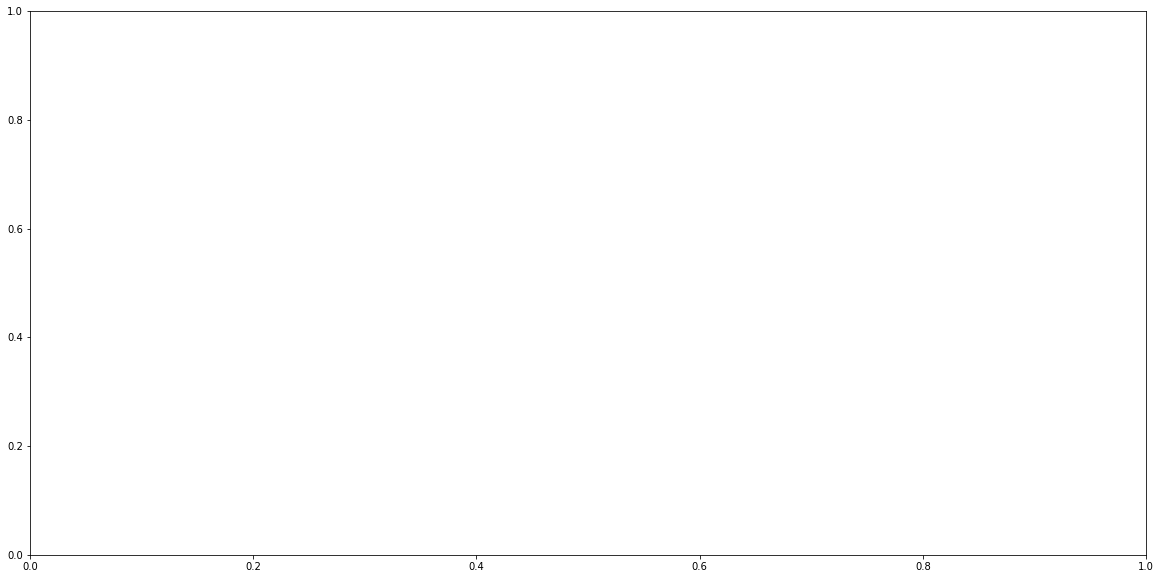

In [1521]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_matches(ax, nir_img, cfp_img[..., 1], keypoints1, keypoints2[:, :2], mapping[inliers], only_matches=True)

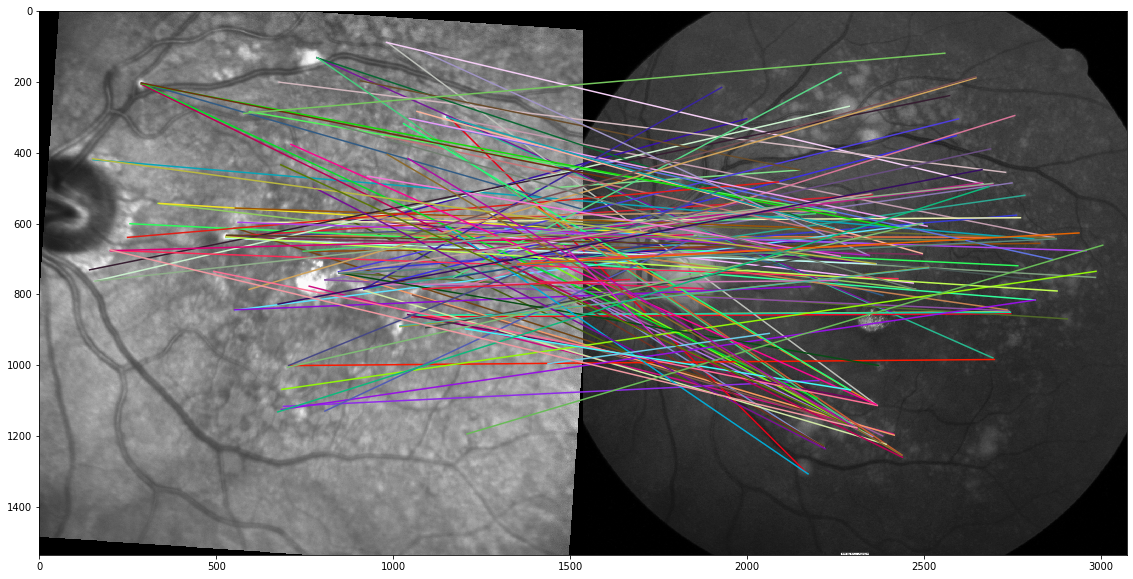

In [40]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_matches(ax, nir_img, cfp_img[..., 1], dest_key, src_key, matches, only_matches=True)

## Test 2D registration

In [26]:
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import AffineTransform, warp, resize
import numpy as np
import eyepy as ep
from skimage.measure import ransac


def orb_detect_extract(img, **kwargs):
    descriptor_extractor = ORB(**kwargs)
    descriptor_extractor.detect_and_extract(img)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors

    return keypoints, descriptors


def rigid_multimodal(
    src_img: np.ndarray,
    dest_img: np.ndarray,
    mp_kwargs: dict = {},
    orb_kwargs: dict = {"n_keypoints": 200},
    ransac_kwargs: dict = {"residual_threshold": 2},
) -> np.ndarray:
    """

    Parameters
    ----------
    src_img :
    dest_img :
    mp_kwargs :
    orb_kwargs :
    ransac_kwargs :

    Returns
    -------

    """
    # Resize images
    src_small = resize(src_img, (500, 500), anti_aliasing=True)
    dest_small = resize(dest_img, (500, 500), anti_aliasing=True)
    #src_small = src_img
    #dest_small = dest_img
    
    # Calculate Mean Phase Image
    src_mp = np.log(ep.preprocess.mean_phase(src_small, **mp_kwargs))
    dest_mp = np.log(ep.preprocess.mean_phase(dest_small, **mp_kwargs))

    # Detect Features
    dest_key, dest_feat = orb_detect_extract(dest_mp, **orb_kwargs)
    src_key, src_feat = orb_detect_extract(src_mp, **orb_kwargs)

    # Match Features
    matches = match_descriptors(dest_feat, src_feat, cross_check=True)

    # Compute Affine
    dest_key = dest_key[:, [1, 0]]
    src_key = src_key[:, [1, 0]]

    model_robust, inliers = ransac(
        (src_key[matches[:, 1]], dest_key[matches[:, 0]]),
        AffineTransform,
        min_samples=3,
        **ransac_kwargs
    )

    # Warp Image
    transformed_src = warp(src_img, model_robust.inverse)

    return transformed_src


In [77]:
[i for i in np.ndindex((4,4))]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [99]:
keys, features = hog_extract(img1, sub_sample_factor=10)

(9, 9, 12, 4800)
[0.02276736 0.         0.         ... 0.02716703 0.06031986 0.04176276]


IndexError: too many indices for array

In [97]:
from annoy import AnnoyIndex
import doctest

def hog_extract(img, orientations=12, pixels_per_cell=(5, 5),
                cells_per_block=(20, 20), rotate_hist=False, sub_sample_factor=2):
    """
    """
    
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, multichannel=False, feature_vector=False)
    
    ss_hog_features = hog_features[::sub_sample_factor, ::sub_sample_factor, ...]

    
    if rotate_hist:
        ss_hog_features = rotate_hog(ss_hog_features)
        
    # flatten blocks
    ss_hog_features = ss_hog_features.reshape(ss_hog_features.shape[:-3] +(-1,))
    print(ss_hog_features.shape)
    keys = []
    features = []
    for key, feature in np.ndenumerate(ss_hog_features):
        
        keys.append(key)
        features.append(feature)
    
    features = np.array(features)
    keys = np.array(features)
    print(keys)
    
    # Rescale features to original image positions
    N0, N1 = pixels_per_cell
    M0, M1 = cells_per_block
    keys[:,0] = (keys[:,0]*N0+(N0*M0/2))*sub_sample_factor
    keys[:,1] = (keys[:,1]*N1+(N1*M1/2))*sub_sample_factor
    
    return keys, features
    

def rotate_hog(hog_features):
    """
    
    
    """
    orientations = hog_features.shape[-1]
    M = hog_features.shape[-2]
    rotated_hog = np.zeros(hog_features.shape[:2]+(orientations, M, M, orientations))
    for block in np.ndindex(hog_features.shape[:2]):
        for rot in range(orientations):
            rotated_hog[block][rot] = np.roll(hog_features[block], rot, axis=-1)
            
    return rotated_hog


def ann(src, dest, n_trees=10, metric="euc"):
    """ Searches ANN for src in dest
    
    For every feature in src the index and distanc of the ann in dest is returned 
    
    Assumes that features are on the last axis
    
    metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"
    """
    orig_src_shape = src.shape[:-1]
    orig_dest_shape = dest.shape[:-1]
    
    # Compress index axis into one axis
    src = src.reshape((np.prod(orig_src_shape), -1))
    dest = dest.reshape((np.prod(orig_dest_shape), -1))
    
    t = AnnoyIndex(dest.shape[-1], 'euclidean')
    for i in range(dest.shape[0]):
        t.add_item(i, dest[i])

    t.build(n_trees)
    
    
    dest_indices = np.empty(src.shape[0], dtype=np.int)
    dest_dist = np.empty(src.shape[0], dtype=np.int)
    for i in range(src.shape[0]):
        ind, dist = t.get_nns_by_vector(src[i], n=1, search_k=-1, 
                                        include_distances=True)
        
        dest_indices[i], dest_dist[i] = ind[0], dist[0]
    
    # Change 1D dest indices to indices of the dest input array
    dest_indices = np.array([[y for y in x] for x in 
                             zip(*np.unravel_index(dest_indices, orig_dest_shape, order='C'))])

    
    # Reshape indices and distances to the input src shape
    dest_dist = dest_dist.reshape(orig_src_shape)
    dest_indices = dest_indices.reshape(orig_src_shape + dest_indices.shape[1:])
    
    return dest_indices, dest_dist

def mutual_ann_match(src_features, dest_features):
    """
    >>> ann1 = np.array([[1,2,3,4],[4,3,2,1],\
                          [1,1,2,2], [3,5,3,4],]).reshape(2,2,4)
                          
    >>> ann2 = np.array([[4,3,2,1], [1,2,3,4],\
                         [1,1,2,3], [1,1,2,4],]).reshape(2,2,4)
                     
    >>> mutual_ann_match(ann1, ann2)
    (array([[[0, 0],
            [0, 1]],
    <BLANKLINE>
           [[0, 1],
            [0, 0]],
    <BLANKLINE>
           [[1, 0],
            [1, 0]]]), array([0, 0, 1]))
    """
    # Compute indices and distances in both directions
    dest_index, dest_dist = ann(src_features, dest_features)
    src_index, src_dist = ann(dest_features, src_features)

    results = []
    
    for i in np.ndindex(dest_index.shape[:-1]):
        # i is the position in the src_index
        # nn_srcdest is the index of the nearest neighbour in dest 
        position_nn_in_src = tuple(dest_index[i])
        nn_in_src = tuple(src_index[position_nn_in_src])
        if i == nn_in_src:
            results.append([dest_dist[i], [i, position_nn_in_src]])
            #matches[i, position_nn_in_src] = dest_dist[i]
    
    results = sorted(results, key= lambda x: x[0])
    matches = np.asarray([x[1] for x in results])
    distances = np.array([x[0] for x in results])
    return matches, distances


doctest.testmod()

def rigid_multimodal2(
    src_img: np.ndarray,
    dest_img: np.ndarray,
    mp_kwargs: dict = {},
    orb_kwargs: dict = {"n_keypoints": 200},
    ransac_kwargs: dict = {"residual_threshold": 2},
) -> np.ndarray:
    """

    Parameters
    ----------
    src_img :
    dest_img :
    mp_kwargs :
    orb_kwargs :
    ransac_kwargs :

    Returns
    -------

    """
    # Resize images
    src_small = resize(src_img, (500, 500), anti_aliasing=True)
    dest_small = resize(dest_img, (500, 500), anti_aliasing=True)
    #src_small = src_img
    #dest_small = dest_img
    
    # Calculate Mean Phase Image
    src_mp = np.log(ep.preprocess.mean_phase(src_small, **mp_kwargs))
    dest_mp = np.log(ep.preprocess.mean_phase(dest_small, **mp_kwargs))

    # Detect Features - HOG
    

    # Match Features - > ANN
    matches, distances = mutual_ann_match(src_feat,
                                      dest_feat)
    new_shape_rotated_nir = (ss_nir_rotated_hog.shape[:3]) + (np.prod(ss_nir_rotated_hog.shape[3:]),)
    new_shape_cfp = (ss_cfp_hog.shape[:2]) + (np.prod(ss_cfp_hog.shape[2:]),)
    matches, distances = mutual_ann_match(ss_cfp_hog.reshape(new_shape_cfp),
                                          ss_nir_rotated_hog.reshape(new_shape_rotated_nir))

    len_m = matches.shape[0]
    mapping = np.tile(np.arange(len_m).reshape(len_m,1), 2)
    keypoints1 = (np.array(matches[:, 0].tolist())*N+(N*M/2))*2
    keypoints2 = (np.array(matches[:, 1].tolist())*N+(N*M/2))*2

    # Compute Affine
    dest_key = dest_key[:, [1, 0]]
    src_key = src_key[:, [1, 0]]

    model_robust, inliers = ransac(
        (src_key[matches[:, 1]], dest_key[matches[:, 0]]),
        AffineTransform,
        min_samples=3,
        **ransac_kwargs
    )

    # Warp Image
    transformed_src = warp(src_img, model_robust.inverse)

    return transformed_src

In [21]:
from skimage import data
from skimage.transform import rotate, AffineTransform, warp
from skimage.color import rgb2gray
import eyepy as ep
import matplotlib.pyplot as plt

img1 = rgb2gray(data.astronaut())
img1 = data.astronaut()[...,2]
tform = AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img2 = warp(data.astronaut()[...,1], tform)

reg_img2 = multimodal_2D(img2, img1)

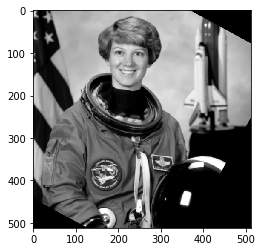

In [22]:
plt.imshow(reg_img2, cmap="gray")

In [39]:
np.fft.fft2(img1)[0,:3]

array([25290362.             +0.j        ,
        -415253.99384918+441447.64428172j,
        -937092.7354362 -876119.41585338j])

In [42]:
-415253.99**2

-172435876210.9201

In [43]:
np.sqrt((-415253.99)**2+41447.644**2)

417317.36532772135

In [27]:
reg_cfp = multimodal_2D(cfp_img[..., 1], nir_img)

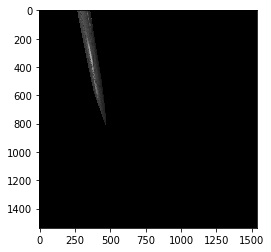

In [28]:
plt.imshow(reg_cfp, cmap="gray")

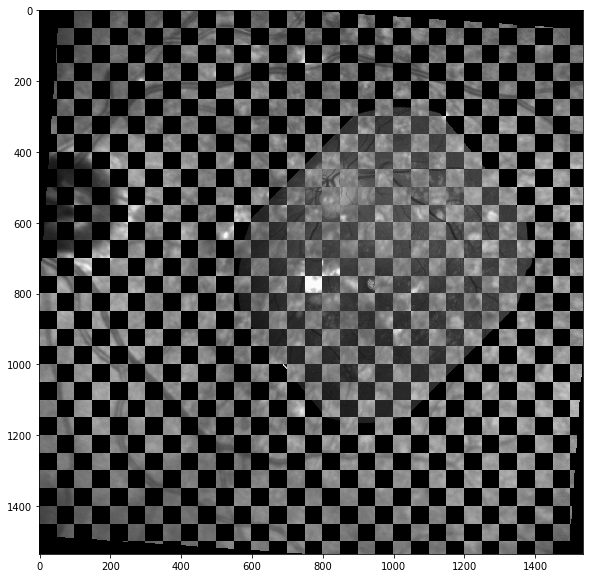

In [12]:
plot_registration_comparison(nir_img, reg_cfp, square_size=50)

In [11]:
from skimage.color import gray2rgb
from skimage.segmentation import checkerboard_level_set

def to_rgb_with_alpha(img, channels_last=True, float_scale=True):
    
    if img.min() < 0:
        msg = "Negative values are not allowed in image"
        raise ValueError(msg)
        
    # Integer data should be scaled 0-255
    if img.dtype == int:
        if img.max() > 255:
            msg = "Images of type int have to be scaled 0 to 255"
        
    # Float data should be scaled 0-1
    if img.dtype == float:
        if img.max() > 1.0:
            msg = "Images of type float have to be scaled 0.0 to 1.0"
            raise ValueError(msg)
    
    if float_scale and img.dtype == int:
        img /= 255
        
    if not float_scale and img.dtype == float:
        img = (img*255).astype(int)
        
    
    img = gray2rgb(img, alpha=True)
    return img
        
        

def plot_registration_comparison(img1, img2, square_size=200, figsize=(10,10)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    
    img1 = to_rgb_with_alpha(img1, float_scale=True)
    img2 = to_rgb_with_alpha(img2, float_scale=True)
    
    alpha = checkerboard_level_set(img1.shape[:-1], square_size).astype(float)
    #alpha[[np.arange(img1.shape[0])],
    #      np.arange(0, img1.shape[1], gridsize[1])] = 1.0
    
    
    #img1[..., -1] = alpha.astype(float)
    img2[..., -1] = alpha#abs(alpha-1)
    ax.imshow(img1)
    ax.imshow(img2)